In [ ]:
!pip install pandas==1.3.5

# Load s3 file

In [1]:
import io
import boto3
import configparser

import numpy as np
import pandas as pd

def read_csv_from_s3(section_name, bucket_name, file_path, ):
    
    parser = configparser.ConfigParser()
    parser.read('./config.ini')
    access_key = parser.get(section_name, "access_key")
    secret_key = parser.get(section_name, "secret_key")
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key, 
                      aws_secret_access_key=secret_key)
    print("Get object")
    obj = s3.get_object(Bucket=bucket_name, Key=file_path)

    print("Read csv")
    df = pd.read_csv( io.BytesIO( obj["Body"].read() ) )
    
    print("Completed")
    print("Data size:", df.shape)

    return df

This notebook was tested on a ml.m5.large notebook instance

In [2]:
section_name = "aws_boto_credentials"
bucket_name = "s3-test-ev"
file_path = "raw/vehicles.csv"

df = read_csv_from_s3(section_name, bucket_name, file_path)

Get object
Read csv
Completed
Data size: (426880, 26)


# EDA - used cars

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [6]:
cols_drop = []

### 1. id

* consists of unique values (exclude to train)

### 2. url

* consists of unique values (drop)

In [7]:
cols_drop.append("url")

### 3. region

In [8]:
col = "region"
df[col].value_counts()[:5]

columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
Name: region, dtype: int64

In [9]:
display(df[col].value_counts().sort_index()[:20])
display(df[col].value_counts().sort_index()[-20:])

SF bay area             2936
abilene                  235
akron / canton          2211
albany                  2537
albuquerque             2952
altoona-johnstown        364
amarillo                 564
ames                     194
anchorage / mat-su      2742
ann arbor               1085
annapolis                285
appleton-oshkosh-FDL    1261
asheville               1423
ashtabula                270
athens                   607
atlanta                 2965
auburn                   142
augusta                  480
austin                  2969
bakersfield             2528
Name: region, dtype: int64

west virginia (old)          8
western IL                  63
western KY                 212
western maryland           285
western massachusetts     2039
western slope             1188
wichita                   1694
wichita falls              589
williamsport               362
wilmington                 975
winchester                 672
winston-salem             1027
worcester / central MA    1914
wyoming                    610
yakima                    1704
york                       777
youngstown                 664
yuba-sutter               1747
yuma                       335
zanesville / cambridge     313
Name: region, dtype: int64

#### 3.1. region with long, lat

In [10]:
# check duplicated region name
region_grp_loc = df.groupby(["long", "lat"])["region"].agg([set]).reset_index()
region_grp_loc["region_cnt"] = region_grp_loc["set"].apply(lambda x: len(x))
region_grp_loc.sort_values(['region_cnt'], ascending=False)

,long,lat,set,region_cnt
20965,-95.785580,37.132840,"{ann arbor, kenai peninsula, space coast, denv...",75
1479,-123.030322,44.927304,"{long island, chico, yuma, lafayette, harrisbu...",55
21825,-95.268600,30.123700,"{roswell / carlsbad, lafayette, del rio / eagl...",43
45797,-80.241520,25.827103,"{ann arbor, baton rouge, kenosha-racine, logan...",41
11663,-112.058490,33.681077,"{denver, bakersfield, phoenix, buffalo, seattl...",40
...,...,...,...,...
21192,-95.622363,36.303847,{tulsa},1
21193,-95.622339,36.303799,{fayetteville},1
21194,-95.621331,30.217831,{houston},1
21195,-95.619987,37.059508,{boston},1


In [11]:
idx_multi = region_grp_loc.region_cnt > 1
region_grp_loc[idx_multi]["set"].drop_duplicates()

67                                       {phoenix, hawaii}
416                  {kenai peninsula, anchorage / mat-su}
493                        {fairbanks, anchorage / mat-su}
495      {kenai peninsula, fairbanks, southeast alaska,...
505                   {anchorage / mat-su, seattle-tacoma}
                               ...                        
59868                   {cape cod / islands, rhode island}
59901    {worcester / central MA, new hampshire, maine,...
59936                    {cape cod / islands, south coast}
59948    {cape cod / islands, south coast, rhode island...
60203    {raleigh / durham / CH, greenville / upstate, ...
Name: set, Length: 3125, dtype: object

In [12]:
df.groupby(["long", "lat", "region"])["id"].count().reset_index()

,long,lat,region,id
0,-159.827728,21.954580,hawaii,1
1,-159.719900,21.973500,hawaii,2
2,-159.707445,21.908386,hawaii,1
3,-159.590001,22.033605,hawaii,3
4,-159.583200,21.907400,hawaii,1
...,...,...,...,...
71845,94.163200,45.557900,st cloud,12
71846,129.287109,40.564085,south jersey,1
71847,139.691700,35.689500,stockton,1
71848,167.629911,77.860640,erie,3


### 4. region_url

* almost values have 1:1 correspondence with region (drop)

In [13]:
cols_drop.extend(["region_url", "region_url_parse"])

In [14]:
df["region_url"].value_counts()

https://spokane.craigslist.org     2988
https://eugene.craigslist.org      2985
https://fresno.craigslist.org      2983
https://orlando.craigslist.org     2983
https://omaha.craigslist.org       2982
                                   ... 
https://nesd.craigslist.org          34
https://bigbend.craigslist.org       30
https://meridian.craigslist.org      28
https://natchez.craigslist.org       14
https://wv.craigslist.org             8
Name: region_url, Length: 413, dtype: int64

In [15]:
df["region_url_parse"] = df["region_url"].apply(lambda x: x.split(".")[0][8:])
df["region_url_parse"].value_counts()

spokane     2988
eugene      2985
fresno      2983
orlando     2983
omaha       2982
            ... 
nesd          34
bigbend       30
meridian      28
natchez       14
wv             8
Name: region_url_parse, Length: 413, dtype: int64

#### 1.4.1. region_url with region

In [16]:
df[["region", "region_url_parse"]]

,region,region_url_parse
0,prescott,prescott
1,fayetteville,fayar
2,florida keys,keys
3,worcester / central MA,worcester
4,greensboro,greensboro
...,...,...
426875,wyoming,wyoming
426876,wyoming,wyoming
426877,wyoming,wyoming
426878,wyoming,wyoming


In [17]:
df[["region", "region_url_parse"]].nunique()

region              404
region_url_parse    413
dtype: int64

In [18]:
region_grp_url = df.groupby(["region"])["region_url_parse"].agg([set]).reset_index()
region_grp_url["url_cnt"] = region_grp_url["set"].apply(lambda x: len(x))
print(region_grp_url.shape)
region_grp_url.sort_values(["url_cnt"], ascending=False).head(15)

(404, 3)


,region,set,url_cnt
157,jackson,"{jxn, jackson, jacksontn}",3
288,richmond,"{richmondin, richmond}",2
222,monroe,"{monroemi, monroe}",2
3,albany,"{albany, albanyga}",2
341,springfield,"{springfield, springfieldil}",2
105,fayetteville,"{fayar, fayetteville}",2
51,charleston,"{charleston, charlestonwv}",2
158,jacksonville,"{onslow, jacksonville}",2
290,rochester,"{rmn, rochester}",2
67,columbus,"{columbusga, columbus}",2


In [19]:
url_grp_region = df.groupby(["region_url_parse"])["region"].agg([set]).reset_index()
url_grp_region["url_cnt"] = url_grp_region["set"].apply(lambda x: len(x))
url_grp_region.sort_values(["url_cnt"], ascending=False).head(5)

,region_url_parse,set,url_cnt
355,stlouis,"{st louis, st louis, MO}",2
121,fortsmith,"{fort smith, fort smith, AR}",2
171,kansascity,"{kansas city, MO, kansas city}",2
0,abilene,{abilene},1
273,palmsprings,{palm springs},1


In [20]:
url_grp_region.loc[171, "set"]

{'kansas city', 'kansas city, MO'}

grouping region  
* ('st louis, MO', 'st louis') -> stlouis
* ('fort smith', 'fort smith, AR') -> fortsmith
* ('kansas city', 'kansas city, MO') -> kansascity

### 5. price (target)

In [21]:
df["price"].describe()

count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64

#### 5.1. outliers

In [22]:
np.quantile(df["price"], [0.05, 0.1, 0.8, 0.9, 0.95, 0.99])

array([    0.,   500., 29777., 37590., 44500., 66995.])

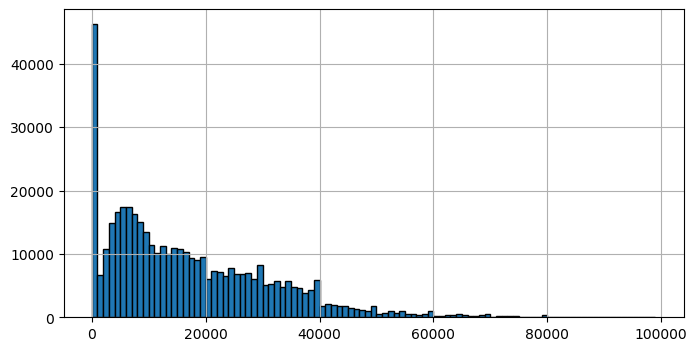

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
df["price"].hist(bins=np.arange(0, 1e5, 1e3), edgecolor="k", ax=ax)
plt.show()

In [24]:
cols_main = [x for x in df.columns if x not in cols_drop+["id", "image_url", "long", "lat", "description"]]

In [25]:
df[df.price.apply(lambda x: True if len(str(x))==10 else False)][cols_main]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
29386,humboldt county,1111111111,1999.0,ford,f350 super duty lariat,good,8 cylinders,diesel,149000.0,clean,automatic,NaN,rwd,full-size,pickup,white,NaN,ca,2021-04-11T11:40:08-0700
37409,modesto,1111111111,2020.0,jeep,NaN,NaN,NaN,gas,1000.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,NaN,ca,2021-04-28T14:29:17-0700
37410,modesto,3009548743,2021.0,chevrolet,NaN,NaN,8 cylinders,gas,1000.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,NaN,ca,2021-04-28T14:28:42-0700
91576,delaware,3024942282,2000.0,mercedes-benz,benz e320,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,de,2021-04-20T08:46:47-0400
153082,indianapolis,1234567890,2006.0,volvo,vnl,fair,NaN,other,200000.0,clean,manual,NaN,NaN,NaN,NaN,black,NaN,in,2021-04-11T11:19:14-0400
184704,frederick,1410065407,1989.0,jeep,wrangler,NaN,NaN,diesel,103000.0,clean,manual,NaN,NaN,NaN,SUV,NaN,NaN,md,2021-04-09T16:02:34-0400
257840,south jersey,3024942282,2000.0,mercedes-benz,benz s430,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,nj,2021-04-20T08:59:55-0400
318592,eugene,3736928711,2007.0,toyota,tundra,excellent,8 cylinders,gas,164000.0,clean,automatic,NaN,4wd,full-size,pickup,silver,NaN,or,2021-04-16T18:16:12-0700
356716,knoxville,3736928711,1999.0,toyota,4runner,fair,6 cylinders,gas,211000.0,clean,automatic,NaN,4wd,mid-size,NaN,green,NaN,tn,2021-04-05T23:15:48-0400


In [26]:
df[df.price.apply(lambda x: True if len(str(x))==9 else False)][cols_main]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
280,birmingham,987654321,1960.0,chevrolet,NaN,NaN,NaN,gas,999999.0,clean,manual,NaN,NaN,NaN,NaN,NaN,NaN,al,2021-05-02T13:24:09-0500
122470,atlanta,987654321,1960.0,chevrolet,NaN,NaN,NaN,gas,9999999.0,clean,manual,NaN,NaN,NaN,NaN,NaN,NaN,ga,2021-05-02T14:00:40-0400
137807,spokane / coeur d'alene,123456789,1999.0,buick,regal,like new,6 cylinders,gas,96000.0,clean,automatic,NaN,fwd,full-size,sedan,white,NaN,id,2021-04-29T08:48:15-0700
193736,ann arbor,123456789,2015.0,chevrolet,cruze,like new,NaN,gas,64181.0,clean,automatic,1G1PC5SB0F7246637,fwd,compact,sedan,red,NaN,mi,2021-05-01T17:44:14-0400
207080,muskegon,123456789,2003.0,NaN,Chevy/gmc,good,8 cylinders,diesel,1234567.0,clean,automatic,NaN,fwd,NaN,pickup,NaN,NaN,mi,2021-05-04T13:57:30-0400
230753,asheville,135008900,2008.0,nissan,titan se kingcab,like new,8 cylinders,gas,110500.0,clean,automatic,NaN,4wd,full-size,truck,grey,NaN,nc,2021-04-16T19:22:21-0400
241404,raleigh / durham / CH,113456789,1980.0,bmw,NaN,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,nc,2021-04-28T08:08:53-0400
288356,akron / canton,123456789,1965.0,chevrolet,project,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,oh,2021-04-05T19:34:36-0400
307488,stillwater,123456789,1996.0,gmc,sierra 2500,fair,8 cylinders,gas,320000.0,clean,automatic,NaN,4wd,full-size,pickup,black,NaN,ok,2021-04-07T12:44:56-0500
358555,nashville,123456789,2021.0,NaN,Rare Car,good,8 cylinders,gas,0.0,clean,other,NaN,rwd,NaN,NaN,NaN,NaN,tn,2021-05-04T20:08:56-0500


In [27]:
df[df.price.apply(lambda x: True if len(str(x))==8 else False)][cols_main]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
1838,dothan,99999999,1993.0,ford,ranger,NaN,NaN,gas,99999.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,al,2021-05-02T17:18:25-0500
136516,spokane / coeur d'alene,17000000,2007.0,ram,2500,good,8 cylinders,diesel,170000.0,rebuilt,automatic,NaN,4wd,full-size,pickup,black,NaN,id,2021-05-02T19:27:17-0700
286323,akron / canton,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,clean,automatic,00000000000000000,4wd,full-size,truck,black,NaN,oh,2021-05-04T11:31:57-0400
286324,akron / canton,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,clean,automatic,00000000000000000,4wd,full-size,truck,black,NaN,oh,2021-05-04T11:31:26-0400
288400,akron / canton,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,clean,automatic,00000000000000000,4wd,full-size,truck,black,NaN,oh,2021-04-05T12:28:23-0400
288401,akron / canton,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,clean,automatic,00000000000000000,4wd,full-size,truck,black,NaN,oh,2021-04-05T12:26:23-0400
300308,mansfield,10004000,2002.0,ford,f350,NaN,NaN,other,215000.0,clean,other,NaN,NaN,NaN,NaN,NaN,NaN,oh,2021-05-04T13:40:11-0400
303014,youngstown,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,clean,automatic,00000000000000000,4wd,full-size,truck,black,NaN,oh,2021-05-04T11:30:10-0400
303644,youngstown,12345678,2019.0,chevrolet,NaN,good,8 cylinders,gas,100000.0,clean,automatic,00000000000000000,4wd,full-size,truck,black,NaN,oh,2021-04-05T12:34:11-0400
353641,jackson,11111111,1966.0,chevrolet,c10,NaN,NaN,gas,111111.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,tn,2021-05-02T16:36:20-0500


In [28]:
df[df.price.apply(lambda x: True if len(str(x))==7 else False)][cols_main]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
26075,fresno / madera,1111111,2014.0,chevrolet,NaN,NaN,NaN,other,11.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,ca,2021-04-30T12:20:06-0700
68935,ventura county,2000000,2002.0,saturn,l-series l200 4dr sedan,good,4 cylinders,gas,164290.0,clean,automatic,NaN,fwd,mid-size,sedan,green,NaN,ca,2021-04-06T16:40:31-0700
83367,eastern CT,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,NaN,NaN,ct,2021-04-11T13:49:50-0400
87052,new haven,1000000,2019.0,NaN,Call for a free estimate,NaN,NaN,gas,12345.0,salvage,automatic,NH738GTD2886R9287,NaN,NaN,NaN,NaN,NaN,ct,2021-04-17T12:33:48-0400
91605,delaware,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,NaN,NaN,de,2021-04-19T09:55:42-0400
91807,delaware,1000000,2022.0,NaN,Any make any model,NaN,NaN,other,364747.0,clean,other,NaN,NaN,NaN,NaN,NaN,NaN,de,2021-04-11T13:51:42-0400
105843,orlando,6995495,2014.0,dodge,journey,NaN,4 cylinders,gas,135888.0,clean,automatic,3C4PDCAB5ET204162,fwd,NaN,SUV,NaN,NaN,fl,2021-04-28T20:11:41-0400
155421,terre haute,1234567,2006.0,jeep,wrangler,like new,6 cylinders,gas,123456.0,clean,automatic,NaN,4wd,mid-size,SUV,custom,NaN,in,2021-04-18T11:26:55-0400
194292,ann arbor,1234567,2010.0,lincoln,mkt ecoboost,like new,NaN,gas,85653.0,clean,automatic,2LMHJ5AT1ABJ50124,NaN,full-size,SUV,custom,NaN,mi,2021-04-16T15:15:44-0400
213918,minneapolis / st paul,1111111,1999.0,chevrolet,corvette,NaN,NaN,gas,200000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,mn,2021-05-04T12:04:16-0500


* drop samples (price >=1e6)

In [29]:
df[df.price.apply(lambda x: True if len(str(x))==6 else False)][cols_main]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
732,birmingham,100000,1984.0,jeep,cj7,NaN,NaN,gas,112000.0,clean,manual,NaN,NaN,NaN,NaN,NaN,NaN,al,2021-04-24T00:28:32-0500
1727,birmingham,130000,2019.0,chevrolet,corvette,like new,8 cylinders,gas,5000.0,clean,automatic,NaN,rwd,NaN,coupe,blue,NaN,al,2021-04-05T22:11:19-0500
2922,huntsville / decatur,140000,2015.0,jeep,renegade,like new,6 cylinders,gas,49658.0,rebuilt,other,NaN,fwd,mid-size,SUV,yellow,NaN,al,2021-04-27T09:21:39-0500
4797,montgomery,104000,2018.0,dodge,NaN,NaN,8 cylinders,other,483.0,clean,automatic,2C3CDZH95JH100203,fwd,compact,other,NaN,NaN,al,2021-04-05T15:50:38-0500
4799,montgomery,100000,2018.0,dodge,NaN,NaN,8 cylinders,other,959.0,clean,automatic,2C3CDZH98JH100129,fwd,compact,other,NaN,NaN,al,2021-04-05T15:46:49-0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419656,madison,119900,2021.0,chevrolet,corvette,good,8 cylinders,gas,601.0,clean,automatic,1G1YC2D49M5106953,rwd,mid-size,coupe,red,NaN,wi,2021-05-04T18:47:19-0500
419756,madison,119995,2004.0,acura,nsx,NaN,6 cylinders,gas,16859.0,clean,manual,JH4NA21614T000075,rwd,NaN,coupe,black,NaN,wi,2021-05-04T07:26:45-0500
420693,madison,125000,2014.0,porsche,911 turbo s,excellent,6 cylinders,gas,10100.0,clean,manual,WP0AD2A93ES167417,4wd,full-size,coupe,black,NaN,wi,2021-04-23T12:43:37-0500
424281,milwaukee,299500,2018.0,NaN,Lamborghini Aventador,NaN,12 cylinders,gas,3171.0,salvage,automatic,ZHWUV4ZD4JLA07642,4wd,sub-compact,coupe,blue,NaN,wi,2021-04-20T22:38:41-0500


In [30]:
idx_exp = df.price.apply(lambda x: True if len(str(x))==6 else False)

price_grp_model = df[idx_exp].groupby(["manufacturer", "model"])["price"].describe().applymap("{:.0f}".format)
price_grp_model.loc[price_grp_model["count"].astype("float")>=5]

count  \
manufacturer  model                                                      
acura         nsx                                                    5   
cadillac      escalade                                              13   
              escalade esv premium & luxury pkgs rear dvd pan...     5   
chevrolet     camaro                                                 5   
              corvette                                              38   
ferrari       458 spider                                             5   
ford          mustang                                                7   
              super duty f-450 pickup                                6   
mercedes-benz amg gt                                                 9   
              g-class                                               14   
porsche       911                                                   16   
ram           1500 trx launch edition 702hp every option #114...     6   
rover         defender 110                                           6   

                                                                    mean  \
manufacturer  model                                                        
acura         nsx                                                 126376   
cadillac      escalade                                            109823   
              escalade esv premium & luxury pkgs rear dvd pan...  126900   
chevrolet     camaro                                              121396   
              corvette                                            115369   
ferrari       458 spider                                          149995   
ford          mustang                                             155384   
              super duty f-450 pickup                             107328   
mercedes-benz amg gt                                              147993   
              g-class                                             149139   
porsche       911                                                 186800   
ram           1500 trx launch edition 702hp every option #114...  131900   
rover         defender 110                                        129888   

                                                                    std  \
manufacturer  model                                                       
acura         nsx                                                 13193   
cadillac      escalade                                             6286   
              escalade esv premium & luxury pkgs rear dvd pan...      0   
chevrolet     camaro                                              11324   
              corvette                                            11402   
ferrari       458 spider                                              0   
ford          mustang                                             52599   
              super duty f-450 pickup                              9812   
mercedes-benz amg gt                                               6016   
              g-class                                             37850   
porsche       911                                                 63494   
ram           1500 trx launch edition 702hp every option #114...   3098   
rover         defender 110                                            0   

                                                                     min  \
manufacturer  model                                                        
acura         nsx                                                 109999   
cadillac      escalade                                            104999   
              escalade esv premium & luxury pkgs rear dvd pan...  126900   
chevrolet     camaro                                              109000   
              corvette                                            100000   
ferrari       458 spider                                          149995   
ford          mustang                                             102999   
   

In [31]:
idx_0 = df.price == 0

df[idx_0][cols_main].describe(include="all")

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
count,32895,32895.0,32863.000000,31434,32319,10180,15627,32476,3.078500e+04,32387,32162,24011,22582,9467,25969,19841,0.0,32895,32889
unique,383,NaN,NaN,40,4172,6,8,5,NaN,6,3,13174,3,4,13,12,NaN,51,32378
top,salem,NaN,NaN,ford,f-150,excellent,6 cylinders,gas,NaN,clean,automatic,5B4KPD27X83433783,4wd,full-size,sedan,white,NaN,ca,2021-05-04T07:40:20-0400
freq,780,NaN,NaN,6130,893,6542,5322,25778,NaN,32250,29713,88,11233,4956,6734,6425,NaN,5255,7
mean,NaN,0.0,2013.973344,NaN,NaN,NaN,NaN,NaN,8.931268e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,6.359100,NaN,NaN,NaN,NaN,NaN,2.970072e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.0,1903.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.0,2012.000000,NaN,NaN,NaN,NaN,NaN,3.490800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,0.0,2015.000000,NaN,NaN,NaN,NaN,NaN,7.200000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,0.0,2017.000000,NaN,NaN,NaN,NaN,NaN,1.100000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
idx_drop = (df.price >= 1.e5) | (df.price < 500)

### 6. year

In [33]:
df.year.describe()

count    425675.000000
mean       2011.235191
std           9.452120
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2017.000000
max        2022.000000
Name: year, dtype: float64

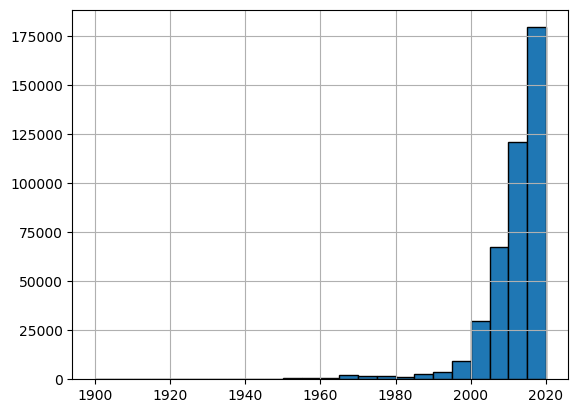

In [34]:
df.year.hist(bins=np.arange(1900, 2025, 5), edgecolor="k")
plt.show()

### 7. manufacturer

* land rover = rover

In [35]:
col = "manufacturer"
df[col].nunique()

42

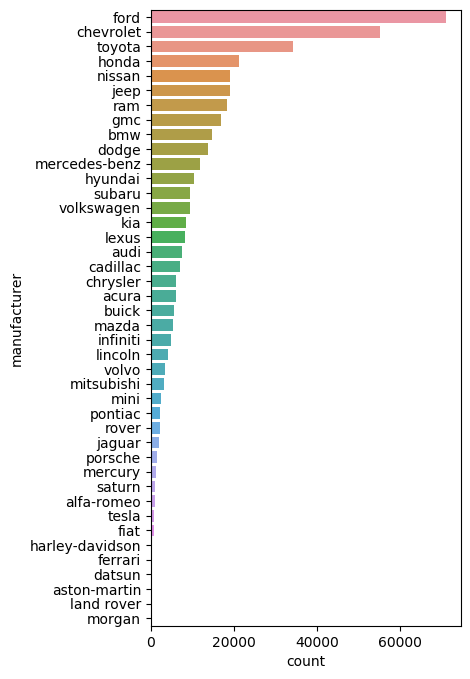

In [36]:
fig, ax = plt.subplots(figsize=(4, 8))
sns.countplot(data=df, y=col, 
              order=df[col].value_counts().index, 
              ax=ax)
plt.show()

#### 7.1. manufacturer with price

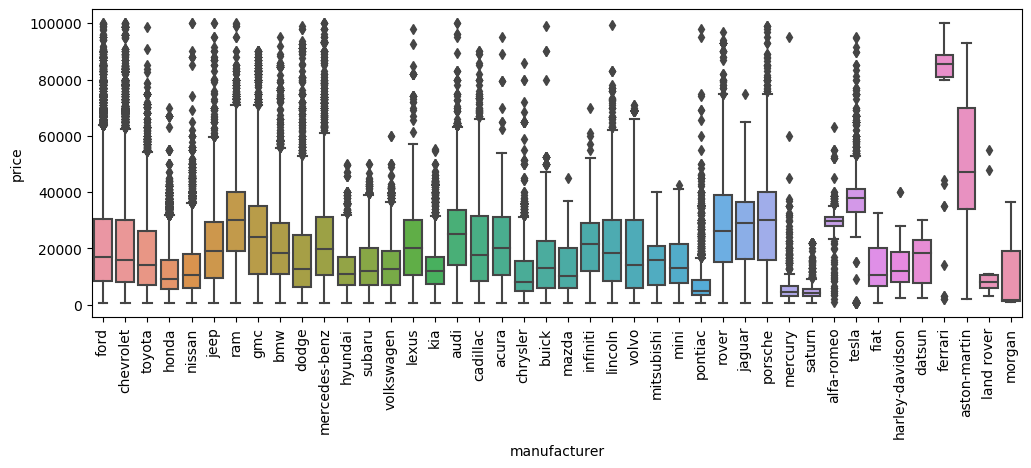

In [37]:
fig, ax = plt.subplots(figsize=(12,4))
lbs = df[~idx_drop][col].value_counts().index
sns.boxplot(data=df[~idx_drop], y='price', x=col, order=lbs, ax=ax)
ax.set_xticklabels(lbs, rotation=90)
plt.show()

In [38]:
df[~idx_drop].groupby([col])["price"].describe().sort_values("mean").applymap("{:.1f}".format)

,count,mean,std,min,25%,50%,75%,max
manufacturer,,,,,,,,
saturn,1060.0,5187.2,4175.9,500.0,2995.0,4235.5,5495.0,22000.0
mercury,1081.0,5990.6,6201.6,500.0,3000.0,4500.0,6495.0,95000.0
pontiac,2209.0,8420.5,9486.7,500.0,3499.0,4995.0,8846.0,98000.0
chrysler,5529.0,11113.2,8885.7,500.0,4850.0,7999.0,15598.0,86000.0
honda,19408.0,11770.7,8423.5,500.0,5500.0,9250.0,16000.0,69891.0
hyundai,9130.0,12133.3,7096.9,500.0,6857.2,10900.0,16990.0,50000.0
fiat,754.0,12487.1,6984.0,500.0,6500.0,10675.0,19990.0,32500.0
kia,7309.0,12819.0,7596.4,500.0,7250.0,11988.0,16990.0,55325.0
morgan,3.0,13100.0,20268.9,1000.0,1400.0,1800.0,19150.0,36500.0


#### 7.2. manufacturer with model

In [39]:
df.groupby([col])["model"].nunique().sort_values(ascending=False)

manufacturer
ford               3874
chevrolet          2611
toyota             1721
mercedes-benz      1201
gmc                1173
bmw                1129
ram                1038
honda              1021
nissan              993
dodge               826
jeep                772
volkswagen          704
audi                646
subaru              610
hyundai             490
lexus               463
kia                 437
cadillac            432
mazda               415
volvo               376
chrysler            351
infiniti            341
buick               337
acura               315
lincoln             251
mitsubishi          224
pontiac             205
jaguar              203
porsche             178
rover               168
mini                163
mercury             111
saturn              102
fiat                 66
tesla                62
harley-davidson      51
alfa-romeo           38
ferrari              31
datsun               20
aston-martin         12
land rover            8
mor

### 8. model

* cleansing required by manufacturer

In [40]:
col = "model"
df[col].isna().sum(), df[col].nunique()

(5277, 29667)

In [41]:
display(df[df.manufacturer=="ford"]["model"].value_counts().sort_index()[:20])
display(df[df.manufacturer=="ford"]["model"].value_counts().sort_index()[20:40])
display(df[df.manufacturer=="ford"]["model"].value_counts().sort_index()[-20:])

"t"                         1
- mustang                   1
-150 xlt                    1
-350                        1
.. ect.                     3
/vmi conversion van         1
100                         2
15 passenger shuttle van    2
150                         6
150 4wd                     1
150 4x4                     1
150 full size van i         1
150 xlt                     1
150 xlt 4x4                 1
1930 shay repoduction       1
1952                        1
1959 f-100                  1
2 door sedan                2
2 dr sedan                  1
2 dr victoria               1
Name: model, dtype: int64

2004 f350 super duty                         1
2011 f-450 4x4 crew cab in-closed utility    3
2017 f-350 ex-cab service utility truck      3
2018 f-250 4x4 crew-cab flatbed truck        3
23 t                                         1
24 ft                                        1
250                                          9
250 super duty xl                            1
250 xlt                                      1
2door deluxe sedan                           1
2dr sedan                                    3
3 window                                     1
3 window pro street coupe                    1
350                                          2
350 4×4 dauly                                1
350 closed utility                           1
350 super duty van                           1
350 supercab 4x4                             1
350 transit high roof                        1
3500                                         3
Name: model, dtype: int64

windstar minivan            1
windstar passenger sport    1
windstar se                 3
windstar sel                4
windstar van                8
windstar wagon              1
windstard                   1
winstar                     3
winstar lx                  1
winstar van                 1
workhorse                   1
xl                          1
xl convertible              1
xls explorer                1
xlt                         1
xlt econoline e350          1
xlt f-350 diesel 4x4        4
xlt f150                    1
xlt x-cab                   1
zx2                         1
Name: model, dtype: int64

In [42]:
df[df.manufacturer=="ford"][["model", "type", "drive", "transmission"]].sample(15)

,model,type,drive,transmission
237127,edge titanium,NaN,NaN,automatic
61195,f-150,NaN,rwd,automatic
365470,f-150,pickup,NaN,automatic
352339,excursion limited,SUV,rwd,automatic
39196,fusion se,sedan,fwd,automatic
197389,f250,NaN,4wd,automatic
369690,fusion platinum sedan 4d,sedan,fwd,other
79955,f-550,other,4wd,automatic
132883,mustang,coupe,fwd,manual
32511,expedition,truck,4wd,automatic


In [43]:
display(df[df.manufacturer=="tesla"]["model"].value_counts().sort_index())
# display(df[df.manufacturer=="ford"]["model"].value_counts().sort_index()[20:40])
# display(df[df.manufacturer=="ford"]["model"].value_counts().sort_index()[-20:])

3                                            1
3 standard range plus                        1
75                                           1
model 3                                     73
model 3 awd dual moter                       1
model 3 blacked out standard range plus      5
model 3 long range                           1
model 3 long range sedan                    18
model 3 mid range                            2
model 3 mid range sedan 4d                  16
model 3 performance                          3
model 3 s x y                                1
model 3 standard range                     275
model 60s                                    1
model s                                    108
model s 100d                                 2
model s 100d awd                             2
model s 70                                   2
model s 70 kwh battery                       1
model s 75                                   4
model s 75d                                  2
model s 75d -

### 9. condition

In [44]:
col = "condition"
df[col].value_counts()

good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: condition, dtype: int64

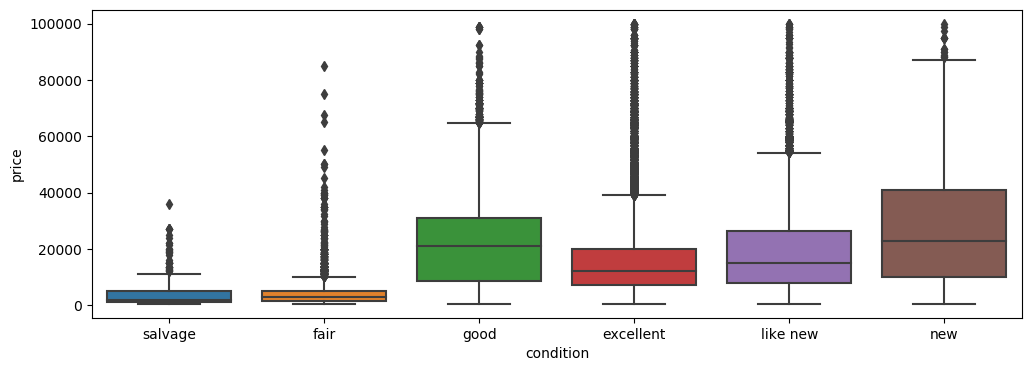

In [45]:
fig, ax = plt.subplots(figsize=(12,4))
lbs = ["salvage", "fair", "good", "excellent", "like new", "new"]
sns.boxplot(data=df[~idx_drop], y='price', x=col, order=lbs, ax=ax)
ax.set_xticklabels(lbs)
plt.show()

In [46]:
df[~idx_drop].groupby([col])["price"].describe().sort_values("mean").applymap("{:.1f}".format)

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
salvage,552.0,3906.6,4796.1,500.0,1000.0,2000.0,4961.2,35989.0
fair,6626.0,4039.1,4558.2,500.0,1600.0,2800.0,4965.0,85000.0
excellent,92559.0,15690.9,12300.3,500.0,7250.0,11998.0,19991.0,99999.0
like new,19550.0,19285.4,15309.7,500.0,7998.0,14995.0,26495.0,99995.0
good,118540.0,21037.7,13076.9,500.0,8500.0,20990.0,30990.0,98900.0
new,986.0,28032.4,21921.6,500.0,9825.0,22942.5,41000.0,99999.0


* "good" is more expensive than "excellent"

### 10. cylinders

In [47]:
col = "cylinders"
df[~idx_drop][col].value_counts()

6 cylinders     86829
4 cylinders     70311
8 cylinders     65473
5 cylinders      1649
10 cylinders     1120
other            1060
3 cylinders       586
12 cylinders      164
Name: cylinders, dtype: int64

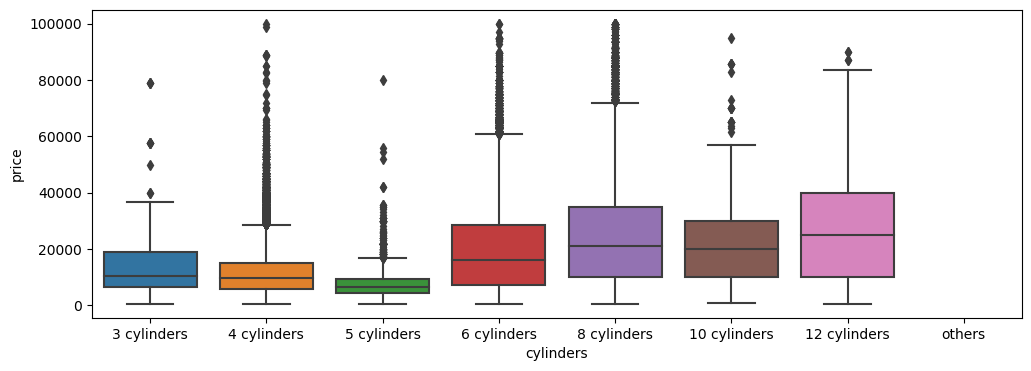

In [48]:
fig, ax = plt.subplots(figsize=(12,4))
lbs = [f"{i} cylinders" for i in [3, 4, 5, 6, 8, 10, 12]] + ["others"]
sns.boxplot(data=df[~idx_drop], y='price', order=lbs, x=col, ax=ax)
plt.show()

#### 10.1. cylinders with type

In [49]:
df.groupby([col, "type"]).size().unstack().fillna(0).astype('int')

type,SUV,bus,convertible,coupe,hatchback,mini-van,offroad,other,pickup,sedan,truck,van,wagon
cylinders,,,,,,,,,,,,,
10 cylinders,116,66,24,61,1,0,1,43,98,172,534,55,38
12 cylinders,12,0,29,48,0,0,0,7,3,77,10,0,0
3 cylinders,110,12,18,74,113,6,0,44,5,143,37,7,29
4 cylinders,18267,48,1373,3215,5857,288,98,1314,775,32362,1257,1001,3687
5 cylinders,159,0,60,75,101,6,4,20,97,695,98,31,165
6 cylinders,27731,114,1852,3973,469,3388,341,5383,9868,18363,7889,3953,1387
8 cylinders,9401,132,2043,5807,148,36,133,2367,16129,5115,19256,1893,250
other,155,22,43,78,107,1,4,219,52,187,150,13,13


#### 10.2. cylinders with year

In [50]:
df.groupby([col])["year"].describe().applymap("{:.0f}".format)

,count,mean,std,min,25%,50%,75%,max
cylinders,,,,,,,,
10 cylinders,1448,2010,7,1968,2003,2010,2015,2021
12 cylinders,209,2005,10,1948,2002,2007,2010,2022
3 cylinders,648,2012,11,1929,2009,2017,2019,2021
4 cylinders,77293,2012,8,1900,2009,2013,2016,2022
5 cylinders,1712,2008,6,1963,2006,2008,2012,2020
6 cylinders,93700,2011,8,1920,2007,2013,2017,2022
8 cylinders,71776,2008,13,1905,2005,2012,2016,2022
other,1298,2008,18,1900,2007,2014,2018,2022


### 11. fuel

In [51]:
col = "fuel"
df[~idx_drop][col].value_counts()

gas         321801
other        27392
diesel       25953
hybrid        4757
electric      1596
Name: fuel, dtype: int64

#### 11.1. fuel with price

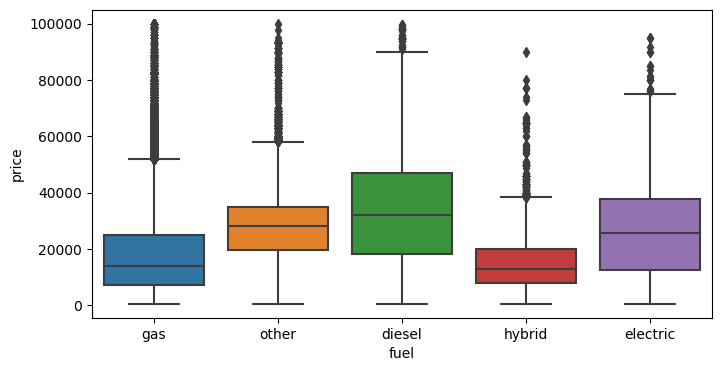

In [52]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=df[~idx_drop], y='price', x=col, ax=ax)
plt.show()

In [53]:
df[~idx_drop].groupby([col])["price"].describe().sort_values("mean").applymap("{:.0f}".format)

,count,mean,std,min,25%,50%,75%,max
fuel,,,,,,,,
hybrid,4757,15820,11022,521,7800,12995,19990,90000
gas,321801,17203,12979,500,6995,13990,24995,99999
electric,1596,26007,16133,500,12590,25590,37590,95000
other,27392,28257,12936,500,19590,27990,34990,99950
diesel,25953,33769,19732,500,17995,31998,46990,99700


* hibrid < gas < electric < other < diesel

#### 11.2. fuel with price, type

In [54]:
# most expensive fuel by type (price: mean)
prc_grp_type_fuel = df[~idx_drop].groupby(["type", "fuel"])["price"].mean().reset_index()
prc_grp_type_fuel.loc[prc_grp_type_fuel.groupby(["type"])["price"].idxmax()]

,type,fuel,price
1,SUV,electric,37171.806202
5,bus,diesel,15594.699029
12,convertible,hybrid,35124.945946
18,coupe,other,29897.036943
23,hatchback,other,21997.960354
24,mini-van,diesel,15662.888889
28,offroad,diesel,24493.000000
35,other,other,33541.438935
36,pickup,diesel,38031.928743
42,sedan,electric,32977.441691


In [55]:
# most expensive fuel by type (price: median)
prc_grp_type_fuel = df[~idx_drop].groupby(["type", "fuel"])["price"].median().reset_index()
prc_grp_type_fuel.loc[prc_grp_type_fuel.groupby(["type"])["price"].idxmax()]

,type,fuel,price
4,SUV,other,27590.0
7,bus,gas,14900.0
12,convertible,hybrid,36197.0
18,coupe,other,30990.0
23,hatchback,other,19990.0
24,mini-van,diesel,14500.0
28,offroad,diesel,18000.0
35,other,other,32990.0
36,pickup,diesel,36990.0
42,sedan,electric,32990.0


### 12. odometer

In [56]:
col = "odometer"
df[col].describe()

count    4.224800e+05
mean     9.804333e+04
std      2.138815e+05
min      0.000000e+00
25%      3.770400e+04
50%      8.554800e+04
75%      1.335425e+05
max      1.000000e+07
Name: odometer, dtype: float64

In [57]:
# 1%, 5%, 10%, 80%, 90%, 95%, 99%
np.quantile(df[df[col].notnull()][col], [0.01, 0.05, 0.1, 0.8, 0.9, 0.95, 0.99])

array([2.000000e+00, 6.318000e+03, 1.493900e+04, 1.457170e+05,
       1.773771e+05, 2.040000e+05, 2.800000e+05])

#### 12.1. outliers

In [58]:
# drop odometer=0
idx = df[col] == 0
df[idx][cols_main]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
538,birmingham,0,2012.0,chevrolet,silverado 2500hd,NaN,8 cylinders,NaN,0.0,clean,automatic,1GC1CVCG6CF139696,rwd,NaN,NaN,white,NaN,al,2021-04-27T19:50:22-0500
563,birmingham,0,2006.0,ford,f550,NaN,NaN,diesel,0.0,clean,other,NaN,NaN,NaN,other,white,NaN,al,2021-04-27T14:10:03-0500
694,birmingham,3980,2013.0,kia,rio,NaN,4 cylinders,gas,0.0,NaN,manual,KNADM4A30D6171594,fwd,NaN,sedan,white,NaN,al,2021-04-24T13:50:11-0500
889,birmingham,0,2006.0,jeep,liberty,NaN,6 cylinders,gas,0.0,clean,automatic,1J8GL48K06W123802,4wd,NaN,SUV,red,NaN,al,2021-04-22T17:40:42-0500
985,birmingham,0,2011.0,chevrolet,cruze,NaN,4 cylinders,gas,0.0,clean,automatic,1G1PJ5S98B7275266,rwd,NaN,sedan,red,NaN,al,2021-04-20T13:20:43-0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425904,wausau,0,2014.0,ram,NaN,NaN,NaN,diesel,0.0,clean,automatic,NaN,NaN,NaN,other,white,NaN,wi,2021-04-20T19:33:56-0500
425905,wausau,0,2014.0,ram,NaN,NaN,NaN,diesel,0.0,clean,automatic,NaN,NaN,NaN,other,white,NaN,wi,2021-04-20T19:30:08-0500
426002,wausau,0,2014.0,ram,NaN,NaN,NaN,diesel,0.0,clean,automatic,NaN,NaN,NaN,other,white,NaN,wi,2021-04-16T02:00:05-0500
426518,wyoming,0,2014.0,ram,NaN,NaN,NaN,diesel,0.0,clean,automatic,NaN,NaN,NaN,other,white,NaN,wy,2021-04-21T22:45:37-0600


In [59]:
# drop odometer=0 and price outliers
df[idx&(~idx_drop)][cols_main]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,posting_date
694,birmingham,3980,2013.0,kia,rio,NaN,4 cylinders,gas,0.0,NaN,manual,KNADM4A30D6171594,fwd,NaN,sedan,white,NaN,al,2021-04-24T13:50:11-0500
1720,birmingham,10477,2009.0,chevrolet,colorado,NaN,NaN,gas,0.0,clean,automatic,1GCCS139X98156780,NaN,NaN,NaN,black,NaN,al,2021-04-06T08:46:53-0500
1804,birmingham,11980,2013.0,infiniti,g37 sedan,NaN,6 cylinders,gas,0.0,NaN,automatic,JN1CV6AP2DM300508,rwd,NaN,sedan,silver,NaN,al,2021-04-04T11:10:27-0500
3959,mobile,4500,1997.0,gmc,sierra,good,6 cylinders,gas,0.0,clean,automatic,NaN,rwd,mid-size,truck,blue,NaN,al,2021-04-28T07:51:45-0500
4267,mobile,4250,1995.0,ford,f150,good,8 cylinders,gas,0.0,clean,automatic,NaN,rwd,full-size,pickup,white,NaN,al,2021-04-14T21:18:18-0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417977,green bay,16900,2013.0,ford,e-350,NaN,NaN,gas,0.0,clean,other,NaN,NaN,NaN,other,white,NaN,wi,2021-04-05T15:07:48-0500
418235,janesville,4900,2011.0,NaN,IC CE PB105,NaN,NaN,diesel,0.0,clean,other,NaN,NaN,NaN,bus,yellow,NaN,wi,2021-04-19T14:07:54-0500
421403,madison,999,2019.0,ford,transit,NaN,NaN,gas,0.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,NaN,wi,2021-04-14T09:10:22-0500
423311,milwaukee,4900,2011.0,NaN,IC CE PB105,NaN,NaN,diesel,0.0,clean,other,NaN,NaN,NaN,bus,yellow,NaN,wi,2021-04-27T15:27:02-0500


In [60]:
df[idx & (~idx_drop)]["condition"].value_counts(dropna=False)

excellent    529
NaN          409
good          79
fair          25
like new      10
new            7
salvage        4
Name: condition, dtype: int64

In [61]:
df[idx & (~idx_drop)]["title_status"].value_counts(dropna=False)

clean         787
NaN           251
missing        10
parts only      8
rebuilt         5
salvage         2
Name: title_status, dtype: int64

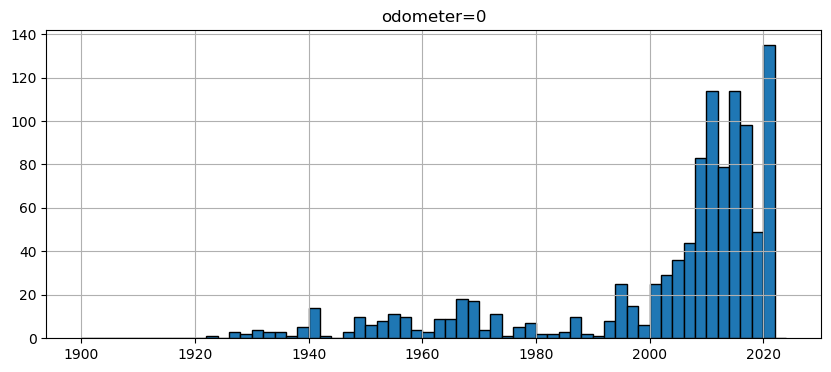

In [62]:
# count year where odometer = 0
fig, ax = plt.subplots(figsize=(10,4))
df[idx&(~idx_drop)]["year"].hist(bins=np.arange(1900, 2025, 2), edgecolor="k", ax=ax)
ax.set_title(f"{col}=0")
plt.show()

In [63]:
idx_drop = (df.price>=1.e5) | (df.price<500) | (df.odometer<100) | (df.odometer>=3e5)
idx_drop.sum()

50239

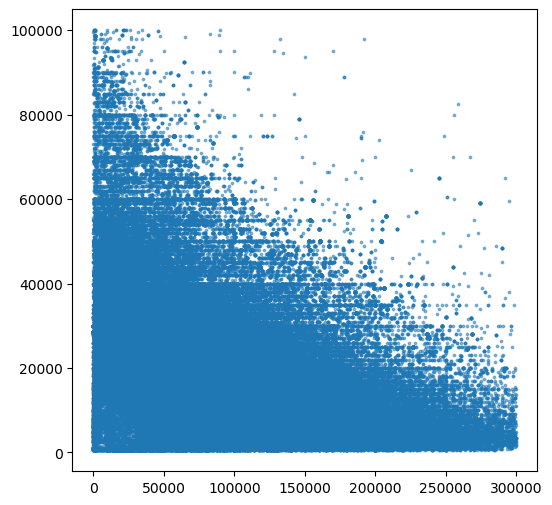

In [65]:
df_pl = df[~idx_drop]

plt.figure(figsize=(6,6))
plt.scatter(df_pl["odometer"], df_pl["price"], s=3, alpha=0.5)
plt.show()

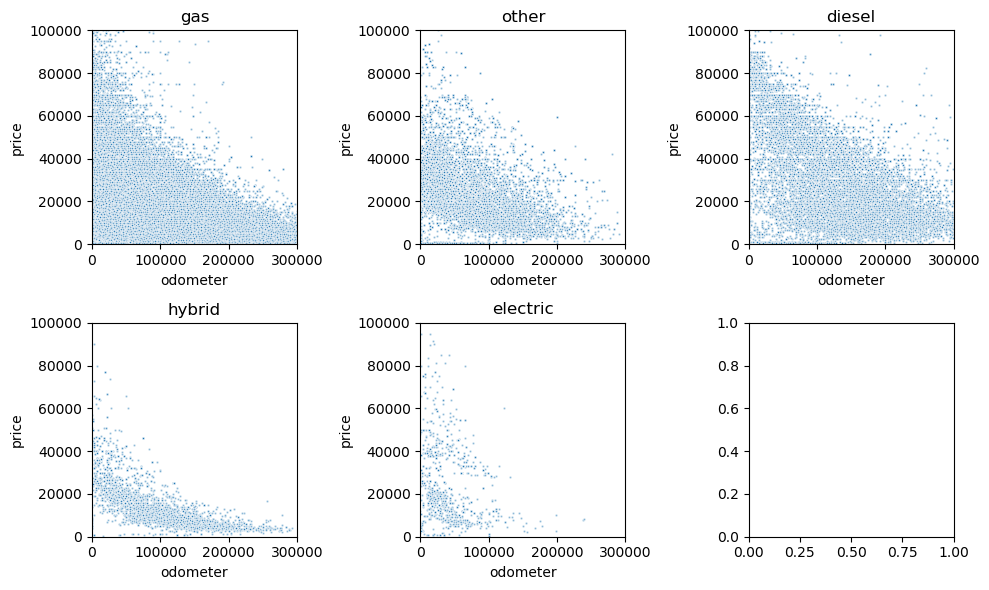

In [66]:
cat = "fuel"
lbs = df[df[cat].notnull()][cat].unique()

fig, axs = plt.subplots(figsize=(10,6), ncols=3, nrows=2)
for ax, lb in zip(axs.flatten(), lbs):
    
    sns.scatterplot(data=df_pl[df_pl[cat]==lb], 
                    x="odometer", y="price", 
                    s=3, alpha=0.5, 
                    ax=ax)

    ax.set_title(lb)
    ax.set_xlim(0, 300000)
    ax.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

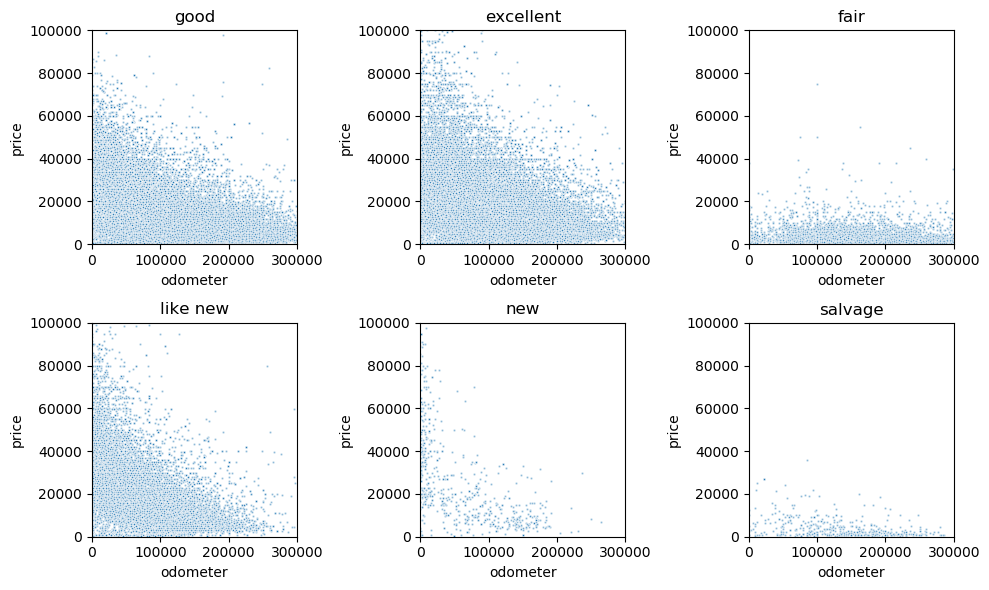

In [67]:
cat = "condition"
lbs = df[df[cat].notnull()][cat].unique()

fig, axs = plt.subplots(figsize=(10,6), ncols=3, nrows=2)
for ax, lb in zip(axs.flatten(), lbs):
    
    sns.scatterplot(data=df_pl[df_pl[cat]==lb], 
                    x="odometer", y="price", 
                    s=3, alpha=0.5, 
                    ax=ax)

    ax.set_title(lb)
    ax.set_xlim(0, 300000)
    ax.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

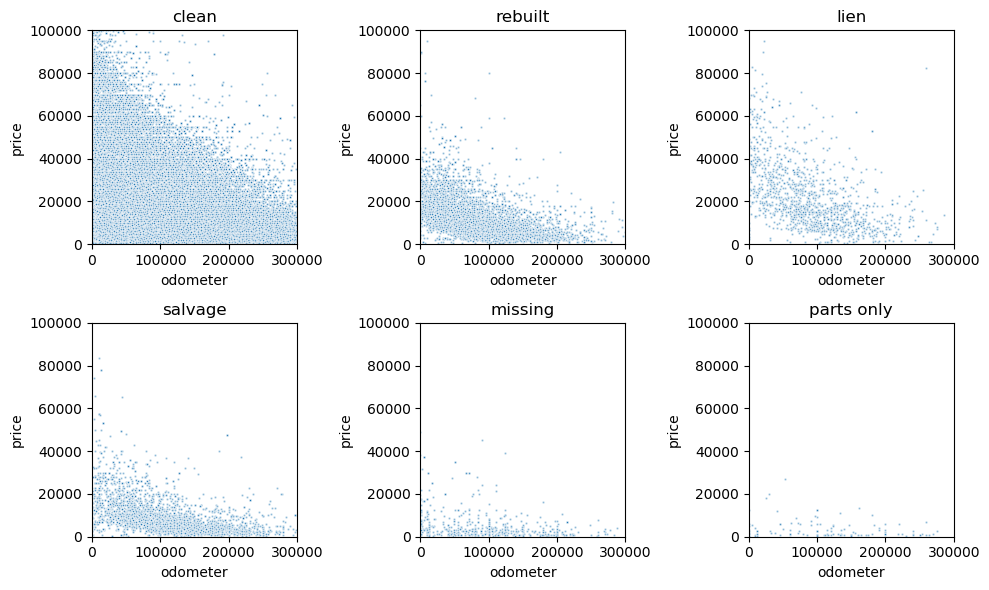

In [68]:
cat = "title_status"
lbs = df[df[cat].notnull()][cat].unique()

fig, axs = plt.subplots(figsize=(10,6), ncols=3, nrows=2)
for ax, lb in zip(axs.flatten(), lbs):
    
    sns.scatterplot(data=df_pl[df_pl[cat]==lb], 
                    x="odometer", y="price", 
                    s=3, alpha=0.5, 
                    ax=ax)

    ax.set_title(lb)
    ax.set_xlim(0, 300000)
    ax.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

### 13. title_status

In [69]:
col = "title_status"
df[col].value_counts()

clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: title_status, dtype: int64

### 13.1. title_status with condition

In [70]:
df.groupby([col, "condition"]).size().unstack()

condition,excellent,fair,good,like new,new,salvage
title_status,,,,,,
clean,91734,6156,118461,19870,1226,225
lien,586,47,389,265,25,3
missing,57,188,208,8,5,49
parts only,18,27,29,9,4,41
rebuilt,2823,142,1362,791,30,23
salvage,880,209,893,235,15,260


* (title_status)="clean" -> (conditon)="salvage" : 225
* (title_status)="salvage" -> (conditon)!="salvage" : ~2200

In [71]:
df[~idx_drop].groupby([col, "condition"]).size().unstack().fillna(0)

condition,excellent,fair,good,like new,new,salvage
title_status,,,,,,
clean,82535.0,5628.0,114080.0,18027.0,655.0,179.0
lien,580.0,41.0,377.0,260.0,23.0,3.0
missing,36.0,159.0,169.0,7.0,2.0,33.0
parts only,9.0,22.0,23.0,7.0,0.0,28.0
rebuilt,2761.0,134.0,1326.0,764.0,29.0,21.0
salvage,854.0,200.0,869.0,224.0,15.0,241.0


### 14. transmission

In [72]:
col = "transmission"
df[col].value_counts()

automatic    336524
other         62682
manual        25118
Name: transmission, dtype: int64

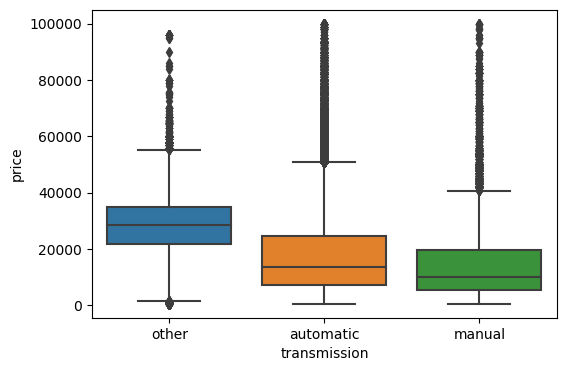

In [73]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=df[~idx_drop], y='price', x=col, ax=ax)
plt.show()

### 15. VIN

VIN (Vehicle Identifier Number)

https://driving-tests.org/vin-decoder/

In [74]:
col = "VIN"
df[col].notnull().sum(), df[col].nunique()

(265838, 118264)

In [75]:
df[col].value_counts()

1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
                    ... 
2G4GP5EX5E9213578      1
1GCEK19J78Z219711      1
JA4AT3AW1AZ006543      1
4T1BF28B61U153724      1
SAJGX2749VCOO8376      1
Name: VIN, Length: 118264, dtype: int64

* VIN - common (manufacturer, model, cylinders, fuel, title_status, tansmission, drive, type, paint_color)

(manufacture)-(model) : (dodge)-(ram)

In [76]:
col_check = "manufacturer"

df_grp = df.groupby(col)[col_check].nunique()
idx_dup_vin = df_grp[df_grp>1].index
df[df[col].isin(idx_dup_vin)].groupby(col)[col_check].agg(set)

VIN
00000000000000000                       {chevrolet, toyota}
11111111111111111        {mazda, chevrolet, honda, mercury}
1234567                                {chevrolet, pontiac}
19UUA66267A021807                            {ford, toyota}
19UUA66285A010806                            {acura, lexus}
1C6RD7GP5CS102305                              {ram, dodge}
1C6RR7FG0DS697066                              {ram, dodge}
1FADP3K2XFL258102                          {ford, chrysler}
1FDWE37L1WHA11298                         {ford, chevrolet}
1FTEW1EP5HFA09219                               {ford, ram}
1FTNE24L89DA76367                              {ford, audi}
1G1PD5SBXE7475984                       {chevrolet, subaru}
1G2AL18F487135452                      {chevrolet, pontiac}
1GKEL19W7XB500718                          {chevrolet, gmc}
1GKKVTED3CJ322495                               {ford, gmc}
1GNLVEED8AS137045                  {ford, chevrolet, dodge}
1GTHC24U05E194431                   

In [77]:
col_check = "model"

df_grp = df.groupby(col)[col_check].nunique()
idx_dup_vin = df_grp[df_grp>1].index
df[df[col].isin(idx_dup_vin)].groupby(col)[col_check].agg(set)

VIN
00000000000000000    {nan, corvette stingray, highlander limited}
00000000000238554       {xv crosstrek 2.0i limited, xv crosstrek}
00000000000594793                 {sierra 2500 hd, sierra 2500hd}
11111111111111111            {nan, acty, b2300, silverado 2500hd}
124379N592337                                     {camaro, rs/ss}
                                         ...                     
ZAM57RTA1E1094669              {Maserati Ghibli, MASERATI GHIBLI}
ZAMBB18A720006592              {maserati sypder, maserati spyder}
ZBBBS00AXD7149578                          {/ bertone x1/9, x1/9}
ZFBCFXBT6GP386424                               {500x easy, 500x}
ZFBERFAT9F6A76965      {promaster city, promaster city cargo van}
Name: model, Length: 2381, dtype: object

[Sample with equal VIN]

In [78]:
df[df[col]=='1C6RD7GP5CS102305']

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date,region_url_parse
146848,7316922983,https://stlouis.craigslist.org/ctd/d/nixa-2012...,"st louis, MO",https://stlouis.craigslist.org,18988,2012.0,dodge,ram1500,excellent,8 cylinders,gas,100348.0,clean,automatic,1C6RD7GP5CS102305,4wd,full-size,truck,silver,https://images.craigslist.org/00y0y_9rCFfAEnN4...,"We are selling our CLEAN, 3 OWNER, ACCIDENT FR...",NaN,il,37.047741,-93.303214,2021-05-04T15:27:59-0500,stlouis
164185,7316922565,https://kansascity.craigslist.org/ctd/d/nixa-2...,"kansas city, MO",https://kansascity.craigslist.org,18988,2012.0,ram,1500,excellent,8 cylinders,gas,100348.0,clean,automatic,1C6RD7GP5CS102305,4wd,full-size,truck,silver,https://images.craigslist.org/00y0y_9rCFfAEnN4...,"We are selling our CLEAN, 3 OWNER, ACCIDENT FR...",NaN,ks,37.047741,-93.303214,2021-05-04T15:27:14-0500,kansascity
221474,7316922427,https://springfield.craigslist.org/ctd/d/nixa-...,springfield,https://springfield.craigslist.org,18988,2012.0,ram,1500,excellent,8 cylinders,gas,100348.0,clean,automatic,1C6RD7GP5CS102305,4wd,full-size,truck,silver,https://images.craigslist.org/00y0y_9rCFfAEnN4...,"We are selling our CLEAN, 3 OWNER, ACCIDENT FR...",NaN,mo,37.047741,-93.303214,2021-05-04T15:27:00-0500,springfield


* 동일 차량이 여러 지역 사이트에 업로드되는 것으로 보임

In [79]:
df[df[col]=='JM1BL1SFXA1196709']

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date,region_url_parse
779,7311421846,https://bham.craigslist.org/ctd/d/siluria-2010...,birmingham,https://bham.craigslist.org,6900,2010.0,mazda,3i,good,4 cylinders,gas,165255.0,rebuilt,automatic,JM1BL1SFXA1196709,fwd,mid-size,sedan,grey,https://images.craigslist.org/00N0N_4i4abv0MuR...,2010 Mazda 3i ; Automatic ; 2.0L Engine ; 4 Cy...,NaN,al,33.243013,-86.817420,2021-04-23T12:00:32-0500,bham
780,7311417807,https://bham.craigslist.org/ctd/d/siluria-2008...,birmingham,https://bham.craigslist.org,8500,2008.0,jeep,commander sport,good,8 cylinders,gas,198000.0,clean,automatic,JM1BL1SFXA1196709,rwd,full-size,SUV,black,https://images.craigslist.org/00q0q_a9Uw5jHRe4...,2008 Jeep Commander Sport ; Automatic ; 4.7L E...,NaN,al,33.243031,-86.817398,2021-04-23T11:54:12-0500,bham


In [80]:
df[df[col]=='3N63M0ZN4FK710243']

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date,region_url_parse
182486,7310504510,https://baltimore.craigslist.org/ctd/d/chesape...,baltimore,https://baltimore.craigslist.org,17366,2015.0,mini,cargo,excellent,4 cylinders,gas,25445.0,clean,automatic,3N63M0ZN4FK710243,fwd,sub-compact,mini-van,black,https://images.craigslist.org/00V0V_hVgIjBJFEF...,"2015 Chevrolet City Express LT Cargo Van, 2.0L...",NaN,md,36.64340,-76.242000,2021-04-21T15:42:43-0400,baltimore
233826,7310482208,https://charlotte.craigslist.org/ctd/d/chesape...,charlotte,https://charlotte.craigslist.org,17366,2015.0,mini,cargo,excellent,4 cylinders,gas,25445.0,clean,automatic,3N63M0ZN4FK710243,fwd,sub-compact,mini-van,black,https://images.craigslist.org/00V0V_hVgIjBJFEF...,"2015 Chevrolet City Express LT Cargo Van, 2.0L...",NaN,nc,36.64340,-76.242000,2021-04-21T15:06:31-0400,charlotte
242338,7310479894,https://raleigh.craigslist.org/ctd/d/chesapeak...,raleigh / durham / CH,https://raleigh.craigslist.org,17366,2015.0,mini,cargo,excellent,4 cylinders,gas,25445.0,clean,automatic,3N63M0ZN4FK710243,fwd,sub-compact,mini-van,black,https://images.craigslist.org/00V0V_hVgIjBJFEF...,"2015 Chevrolet City Express LT Cargo Van, 2.0L...",NaN,nc,36.64340,-76.242000,2021-04-21T15:02:58-0400,raleigh
394269,7310477461,https://norfolk.craigslist.org/ctd/d/chesapeak...,norfolk / hampton roads,https://norfolk.craigslist.org,17366,2015.0,chevrolet,city express lt cargo,excellent,4 cylinders,gas,25445.0,clean,automatic,3N63M0ZN4FK710243,fwd,sub-compact,mini-van,black,https://images.craigslist.org/00V0V_hVgIjBJFEF...,"2015 Chevrolet City Express LT Cargo Van, 2.0L...",NaN,va,36.68829,-76.230521,2021-04-21T14:58:56-0400,norfolk


In [81]:
# outliers
df[df[col].apply(lambda x: str(x).isdigit())].groupby([col]).size().sort_values()

VIN
000                   1
14385554              1
1422360347            1
1412590               1
1402668737            1
                     ..
00000000000000000    19
11111111111111111    24
14141414141414141    52
15151515151515151    81
13131313131313131    85
Length: 339, dtype: int64

### 16. drive

In [82]:
col = "drive"
df[col].value_counts()

4wd    131904
fwd    105517
rwd     58892
Name: drive, dtype: int64

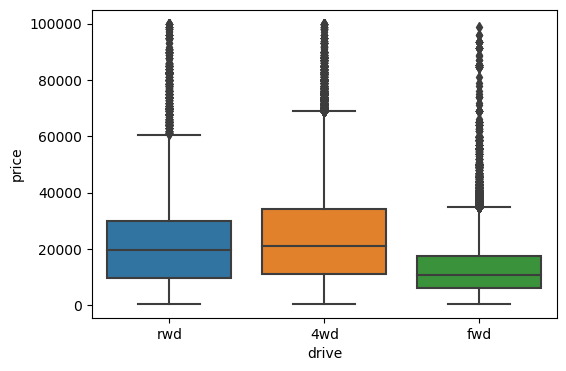

In [83]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=df[~idx_drop], y='price', x=col, ax=ax)
plt.show()

In [84]:
df.groupby(["type", col])["price"].mean().unstack()

drive,4wd,fwd,rwd
type,,,
SUV,16356.015992,14010.735288,13961.529396
bus,15563.000000,7500.352941,15825.709343
convertible,24776.536264,11037.883871,21749.748236
coupe,24846.736626,9704.832902,25361.472434
hatchback,14186.390883,12335.831994,15410.701087
mini-van,9598.367816,9244.002090,12811.764331
offroad,16105.071942,7722.727273,11280.416667
other,28712.221501,22875.297423,26422.019057
pickup,172617.262180,87040.696560,242153.605247


### 17. size

In [85]:
col = "size"
df[col].value_counts()

full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: size, dtype: int64

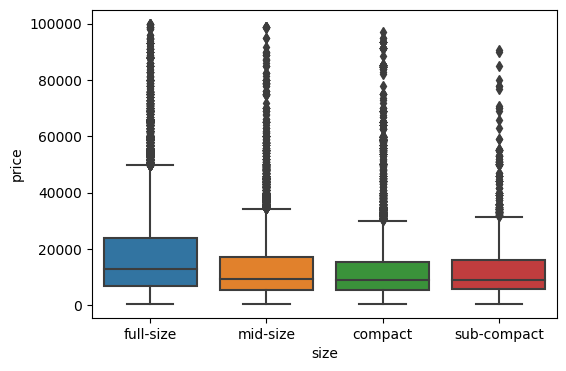

In [86]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=df[~idx_drop], y='price', x=col, ax=ax)
plt.show()

In [87]:
ord_lbs = ["full-size", "mid-size", "compact", "sub-compact"]
df[~idx_drop].groupby(["type", col])["price"].median().unstack()[ord_lbs].sort_values(["full-size"]).applymap("{:.0f}".format)

size,full-size,mid-size,compact,sub-compact
type,,,,
mini-van,5995,6000,7000,17366
wagon,7425,8248,11633,4000
bus,7500,11650,4000,15000
hatchback,7500,7900,6995,7000
sedan,7500,7900,7999,6995
other,10995,8000,50130,5495
SUV,11500,11968,12998,7845
coupe,12999,11975,8750,14500
van,13997,14250,12997,8900


### 18. type

In [88]:
col = "type"
df[col].value_counts()

sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: type, dtype: int64

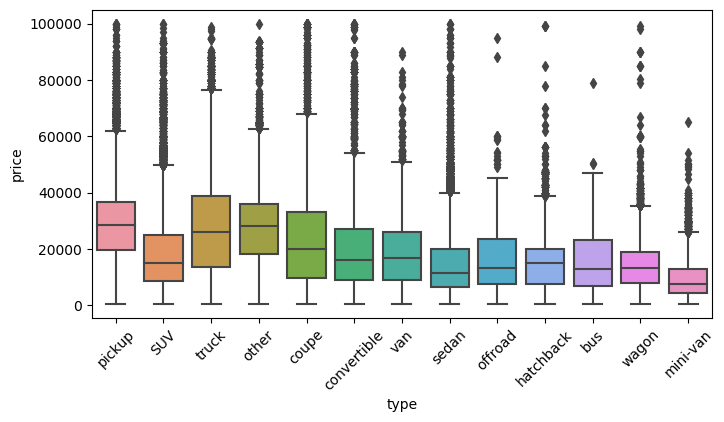

In [89]:
fig, ax = plt.subplots(figsize=(8,4))
lbs = df.groupby([col])["price"].mean().sort_values(ascending=False).index
sns.boxplot(data=df[~idx_drop], y='price', x=col, order=lbs, ax=ax)
ax.set_xticklabels(lbs, rotation=45)
plt.show()

### 19. paint_color

In [90]:
col = "paint_color"
df[col].value_counts()

white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
orange     1984
purple      687
Name: paint_color, dtype: int64

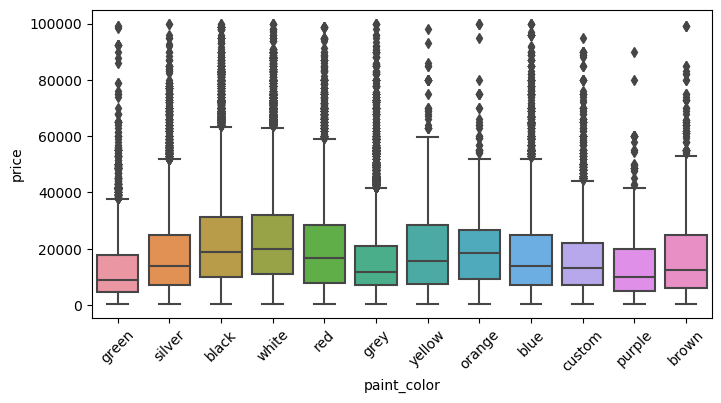

In [91]:
fig, ax = plt.subplots(figsize=(8,4))
lbs = df.groupby([col])["price"].mean().sort_values(ascending=False).index
sns.boxplot(data=df[~idx_drop], y='price', x=col, order=lbs, ax=ax)
ax.set_xticklabels(lbs, rotation=45)
plt.show()

### 20. image_url

* drop

In [92]:
cols_drop.append("image_url")

In [93]:
col = "image_url"
df.shape[0], df[col].nunique(), df[col].isnull().sum()

(426880, 241899, 68)

### 21. description

* drop

In [95]:
cols_drop.append("description")

In [96]:
col = "description"
df[col].sample(10)

255778    I am selling my camry because I have purchased...
367715    SOLD!!!   This Ford Explorer has just been Sol...
320292    Carz Planet          STOCK #:  6999    💲 💲 FOR...
158924    2013  JEEP WRANGLER Oscar Mike Sport Utility  ...
36798     2018 RAM 1500 Laramie EcoDiesel Crew Cab 1-Own...
185775    2016 Chevrolet Chevy Silverado 1500 LS Crew Ca...
308912    Check Out This Totally Awesome 2016 Mitsubishi...
56838     2019 Ram 2500 Power Wagon 4WD 4D Crew Cab  8 c...
360241    2021 *GMC* *Sierra 1500* 21 GMC SIERRA 1500, A...
272771    2014 Chevrolet Chevy Corvette Stingray 2dr Z51...
Name: description, dtype: object

### 22. county

* drop

In [97]:
cols_drop.append("county")

### 23. state

In [98]:
col = "state"
df[col].nunique()

51

In [99]:
df[col].value_counts().head(10)

ca    50614
fl    28511
tx    22945
ny    19386
oh    17696
or    17104
mi    16900
nc    15277
wa    13861
pa    13753
Name: state, dtype: int64

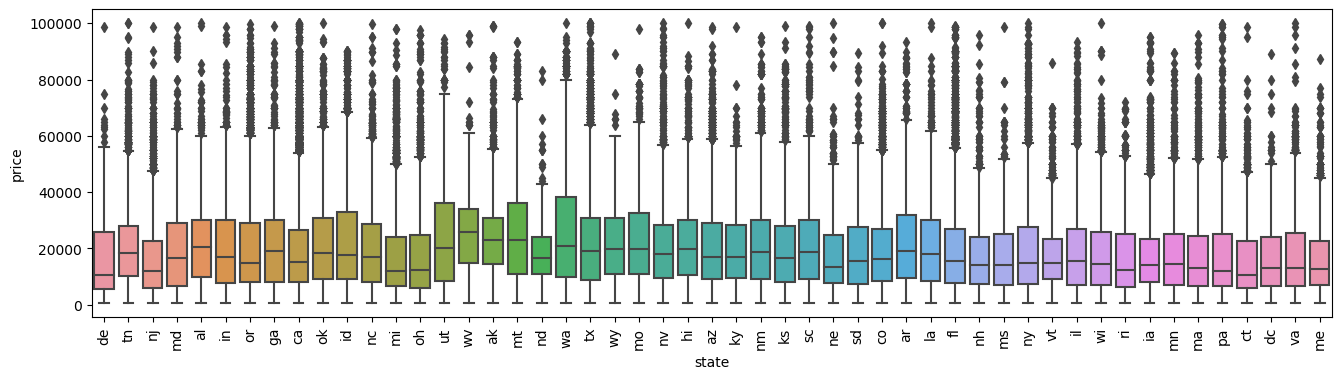

In [100]:
fig, ax = plt.subplots(figsize=(16,4))
lbs = df.groupby([col])["price"].mean().sort_values(ascending=False).index
sns.boxplot(data=df[~idx_drop], y='price', x=col, order=lbs, ax=ax)
ax.set_xticklabels(lbs, rotation=90)
plt.show()

### 24. lat & long

* drop

In [101]:
cols_drop.extend(["lat", "long"])

### 25. posting_date

In [102]:
col = "posting_date"
df[col] = pd.to_datetime(df[col], utc=True).dt.date
df[col]

0                NaT
1                NaT
2                NaT
3                NaT
4                NaT
             ...    
426875    2021-04-04
426876    2021-04-04
426877    2021-04-04
426878    2021-04-04
426879    2021-04-04
Name: posting_date, Length: 426880, dtype: object

In [103]:
df["posting_year"] = pd.to_datetime(df[col]).dt.year # 현재는 단일값으로 학습에는 활용하지 않음
df["posting_day"] = pd.to_datetime(df[col]).dt.dayofyear

df[["posting_date", "posting_year", "posting_day"]].sample(10)

,posting_date,posting_year,posting_day
376722,2021-04-29,2021.0,119.0
305567,2021-04-26,2021.0,116.0
233683,2021-04-22,2021.0,112.0
133198,2021-04-26,2021.0,116.0
166942,2021-04-23,2021.0,113.0
73292,2021-04-27,2021.0,117.0
350140,2021-04-08,2021.0,98.0
157802,2021-04-21,2021.0,111.0
326096,2021-04-27,2021.0,117.0
39317,2021-04-13,2021.0,103.0


In [104]:
cols_drop

['url',
 'region_url',
 'region_url_parse',
 'image_url',
 'description',
 'county',
 'lat',
 'long']